In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

In [3]:
from scipy.signal import lti

def synthetic_neuron(drive):
    """
    Simulates a mock neuron with a time step of 1ms.
    Arguments:
    drive - input to the neuron (expect zero mean; SD=1)
    Returns:
    rho - response function (0=non-spike and 1=spike at each time step)
    """
    dt = .001
    T = dt*len(drive)
    time = np.arange(0, T, dt)
    lagSteps = int(.02/dt)
    drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:]))
    system = scipy.signal.lti([1], [.03**2, 2*.03, 1])
    _, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time)
    rate = np.divide(30, 1 + np.exp(50*(.05-L)))
    spikeProb = rate*dt
    return np.random.rand(len(spikeProb)) < spikeProb

In [4]:
def stavg(stim, resp, win=40):
    """get spike-triggered average"""
    spikes = np.where(resp == 1)[0]
    spikes = spikes[spikes >= win]
    inputs = np.zeros((spikes.shape[0], win))

    for s_i in xrange(spikes.shape[0]):
        s_t = spikes[s_i]
        inputs[s_i] = stim[s_t-win:s_t].reshape((win,))

    return np.average(inputs, axis=0)

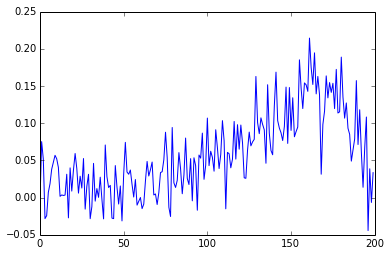

In [7]:
new_noise = np.random.normal(0, 1, size=100*1000)
n_res = synthetic_neuron(new_noise)
in_avg = stavg(new_noise, n_res, win=200)
plt.plot(in_avg)

In [8]:
avg_rate = np.sum(n_res) / float(n_res.shape[0])
kernel = (avg_rate * in_avg)

In [9]:
lin_est = np.convolve(new_noise, kernel, mode='same')

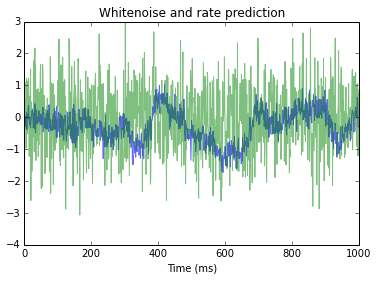

In [19]:
plt.plot(lin_est[:1000]*60, alpha=0.6)
plt.plot(new_noise[:1000], alpha=0.5)
plt.title("Whitenoise and rate prediction")
plt.xlabel("Time (ms)")
plt.savefig("lin-model")

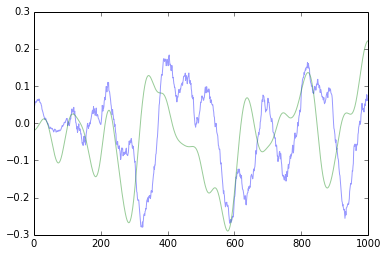

In [18]:
# smoothing experiment
from scipy.ndimage.filters import gaussian_filter1d

def smooth_experiment():
    """In function for scope reasons"""
    col_noise = gaussian_filter1d(new_noise[:1000], sigma=20)
    n_res = synthetic_neuron(col_noise)
    in_avg = stavg(col_noise, n_res, 200)
    avg_rate = np.sum(n_res) / float(n_res.shape[0])
    kernel = (avg_rate * in_avg)
    lin_est = np.convolve(new_noise[:1000], kernel, mode='same')
    return (lin_est, col_noise)

smooth = smooth_experiment()
plt.plot(smooth[0][:1000]*60, alpha=0.4)
plt.plot(smooth[1][:1000], alpha=0.4)

In [20]:
from scipy.optimize import curve_fit

In [23]:
multi_res = []
for _ in range(250):
    multi_res.append(synthetic_neuron(new_noise))

multi_trial_rate = np.zeros((multi_res[0].shape[0]/10, len(multi_res)))
for z_i, m_r in enumerate(multi_res):
    multi_trial_rate[:, z_i] = np.sum(m_r.reshape(-1, 10), axis=1)

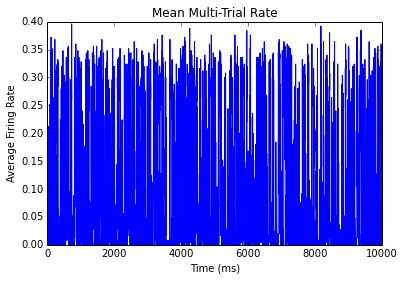

In [24]:
plt.plot(np.mean(multi_trial_rate, axis=1))
plt.title("Mean Multi-Trial Rate")
plt.xlabel("Time (ms)")
plt.ylabel("Average Firing Rate")
plt.savefig("multi-rate")

In [25]:
print(lin_est.shape)
mean_multi = np.mean(multi_trial_rate, axis=1)
print(mean_multi.shape)

(100000,)
(10000,)


In [26]:
r_max = np.max(mean_multi)

def tan_func(x, g2, l0):
    return r_max  *  (np.tanh( g2*(x-l0) ) > 0)

def sigmoid(x, g1, l0):
    return r_max  /  (1 + np.exp(g1*(l0-x)))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

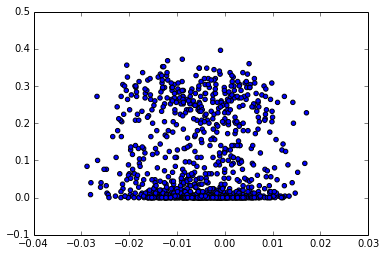

In [56]:
win = 1000
plt.scatter(lin_est[:win], mean_multi[:win])
#plt.plot(curve_fit(tan_func, lin_est[:win], mean_multi[:win]))
plt.plot(curve_fit(sigmoid, lin_est[:win], mean_multi[:win]))
plt.ylabel("$r(t)$")
plt.xlabel("$L(t)$")
plt.savefig("non-lin")

In [39]:
tmp = lin_est[lin_est < -0.04]
f_res = tmp[tmp > -0.041]
print(f_res)

[-0.04017087 -0.04048399 -0.04082107 -0.04017201 -0.04091646 -0.04063069
 -0.04038142 -0.04085586]


In [50]:
def compress(arr, steps=200):
    bins = np.linspace(np.min(arr), np.max(arr), steps)
    avg = []

    for b_i in range(bins.shape[0]-1):
        tmp = arr[arr > bins[b_i]]
        avg.append(np.mean(tmp[tmp < bins[b_i+1]]))
    return avg
    

lin_avg = compress(lin_est)
multi_avg = compress(mean_multi)

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


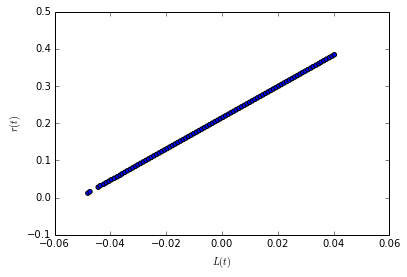

In [51]:
plt.scatter(lin_avg, multi_avg)
#plt.plot(curve_fit(tan_func, lin_est[:10000], mean_multi))
#plt.plot(curve_fit(sigmoid, lin_est[:10000], mean_multi))
plt.ylabel("$r(t)$")
plt.xlabel("$L(t)$")
plt.savefig("non-lin")